This notebook is based on the file [Validation programming exercise](https://colab.research.google.com/notebooks/mlcc/validation.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=validation-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Validation

**Learning Objectives:**
  * Use multiple features, instead of a single feature, to further improve the effectiveness of a model
  * Debug issues in model input data
  * Use a test data set to check if a model is overfitting the validation data

As in the prior exercises, we're working with the [California housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), to try and predict `median_house_value` at the city block level from 1990 census data.

## Setup

First off, let's load up and prepare our data. This time, we're going to work with multiple features, so we'll modularize the logic for preprocessing the features a bit:

In [1]:
# Load packages
using Plots
gr()
using DataFrames
using TensorFlow
import CSV

# Start a TensorFlow session and load the data
sess=Session()
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
#california_housing_dataframe = california_housing_dataframe[shuffle(1:size(california_housing_dataframe, 1)),:];

In [2]:
function preprocess_features(california_housing_dataframe)
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [:latitude,
     :longitude,
     :housing_median_age,
     :total_rooms,
     :total_bedrooms,
     :population,
     :households,
     :median_income]]
  processed_features = selected_features
  # Create a synthetic feature.
  processed_features[:rooms_per_person] = (
    california_housing_dataframe[:total_rooms] ./
    california_housing_dataframe[:population])
  return processed_features
end
    
function preprocess_targets(california_housing_dataframe)
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets[:median_house_value] = (
    california_housing_dataframe[:median_house_value] ./ 1000.0)
  return output_targets
end

preprocess_targets (generic function with 1 method)

2018-08-13 20:57:14.513944: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


For the **training set**, we'll choose the first 12000 examples, out of the total of 17000.

In [3]:
training_examples = preprocess_features(head(california_housing_dataframe,12000))
describe(training_examples)

9×8 DataFrames.DataFrame. Omitted printing of 2 columns
│ Row │ variable           │ mean    │ min       │ median  │ max     │ nunique │
├─────┼────────────────────┼─────────┼───────────┼─────────┼─────────┼─────────┤
│ 1   │ latitude           │ 34.6146 │ 32.54     │ 34.05   │ 41.82   │         │
│ 2   │ longitude          │ -118.47 │ -121.39   │ -118.21 │ -114.31 │         │
│ 3   │ housing_median_age │ 27.4683 │ 1.0       │ 28.0    │ 52.0    │         │
│ 4   │ total_rooms        │ 2655.68 │ 2.0       │ 2113.5  │ 37937.0 │         │
│ 5   │ total_bedrooms     │ 547.057 │ 2.0       │ 438.0   │ 5471.0  │         │
│ 6   │ population         │ 1476.01 │ 3.0       │ 1207.0  │ 35682.0 │         │
│ 7   │ households         │ 505.384 │ 2.0       │ 411.0   │ 5189.0  │         │
│ 8   │ median_income      │ 3.79505 │ 0.4999    │ 3.46225 │ 15.0001 │         │
│ 9   │ rooms_per_person   │ 1.94018 │ 0.0180649 │ 1.88088 │ 55.2222 │         │

In [4]:
training_targets = preprocess_targets(head(california_housing_dataframe,12000))
describe(training_targets)

1×8 DataFrames.DataFrame. Omitted printing of 2 columns
│ Row │ variable           │ mean    │ min    │ median │ max     │ nunique │
├─────┼────────────────────┼─────────┼────────┼────────┼─────────┼─────────┤
│ 1   │ median_house_value │ 198.038 │ 14.999 │ 170.5  │ 500.001 │         │

For the **validation set**, we'll choose the last 5000 examples, out of the total of 17000.

In [5]:
validation_examples = preprocess_features(tail(california_housing_dataframe,5000))
describe(validation_examples)

9×8 DataFrames.DataFrame. Omitted printing of 2 columns
│ Row │ variable           │ mean     │ min      │ median  │ max     │ nunique │
├─────┼────────────────────┼──────────┼──────────┼─────────┼─────────┼─────────┤
│ 1   │ latitude           │ 38.0508  │ 36.14    │ 37.79   │ 41.95   │         │
│ 2   │ longitude          │ -122.183 │ -124.35  │ -122.14 │ -121.39 │         │
│ 3   │ housing_median_age │ 31.2798  │ 1.0      │ 31.0    │ 52.0    │         │
│ 4   │ total_rooms        │ 2614.82  │ 8.0      │ 2164.0  │ 32627.0 │         │
│ 5   │ total_bedrooms     │ 521.06   │ 1.0      │ 424.0   │ 6445.0  │         │
│ 6   │ population         │ 1318.13  │ 8.0      │ 1074.0  │ 28566.0 │         │
│ 7   │ households         │ 491.232  │ 1.0      │ 403.0   │ 6082.0  │         │
│ 8   │ median_income      │ 4.09605  │ 0.4999   │ 3.72845 │ 15.0001 │         │
│ 9   │ rooms_per_person   │ 2.07878  │ 0.135721 │ 2.06628 │ 18.2553 │         │

In [6]:
validation_targets = preprocess_targets(tail(california_housing_dataframe,5000))
describe(validation_targets)

1×8 DataFrames.DataFrame. Omitted printing of 2 columns
│ Row │ variable           │ mean    │ min    │ median │ max     │ nunique │
├─────┼────────────────────┼─────────┼────────┼────────┼─────────┼─────────┤
│ 1   │ median_house_value │ 229.533 │ 14.999 │ 213.0  │ 500.001 │         │

## Task 1: Examine the Data
Okay, let's look at the data above. We have `9` input features that we can use.

Take a quick skim over the table of values. Everything look okay? See how many issues you can spot. Don't worry if you don't have a background in statistics; common sense  will get you far.

After you've had a chance to look over the data yourself, check the solution for some additional thoughts on how to verify data.

### Solution

Let's check our data against some baseline expectations:

* For some values, like `median_house_value`, we can check to see if these values fall within reasonable ranges (keeping in mind this was 1990 data — not today!).

* For other values, like `latitude` and `longitude`, we can do a quick check to see if these line up with expected values from a quick Google search.

If you look closely, you may see some oddities:

* `median_income` is on a scale from about 3 to 15. It's not at all clear what this scale refers to—looks like maybe some log scale? It's not documented anywhere; all we can assume is that higher values correspond to higher income.

* The maximum `median_house_value` is 500,001. This looks like an artificial cap of some kind.

* Our `rooms_per_person` feature is generally on a sane scale, with a 75th percentile value of about 2. But there are some very large values, like 18 or 55, which may show some amount of corruption in the data.

We'll use these features as given for now. But hopefully these kinds of examples can help to build a little intuition about how to check data that comes to you from an unknown source.

## Task 2: Plot Latitude/Longitude vs. Median House Value

Let's take a close look at two features in particular: **`latitude`** and **`longitude`**. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot `latitude` and `longitude`, and use color to show the `median_house_value`.

In [7]:
ax1=scatter(validation_examples[:longitude],
            validation_examples[:latitude],
            color=:coolwarm,
            zcolor=validation_targets[:median_house_value] ./ maximum(validation_targets[:median_house_value]),
            ms=5,
            markerstrokecolor=false,
            title="Validation Data",
            ylim=[32,43],
            xlim=[-126,-112])

ax2=scatter(training_examples[:longitude],
            training_examples[:latitude],
            color=:coolwarm,
            zcolor=training_targets[:median_house_value] ./ maximum(training_targets[:median_house_value]),
            markerstrokecolor=false,
            ms=5,
            title="Training Data",
            ylim=[32,43],
            xlim=[-126,-112])

plot(ax1, ax2, legend=false, colorbar=false, layout=(1,2))

Wait a second...this should have given us a nice map of the state of California, with red showing up in expensive areas like the San Francisco and Los Angeles.

The training set sort of does, compared to a [real map](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55), but the validation set clearly doesn't.

**Go back up and look at the data from Task 1 again.**

Do you see any other differences in the distributions of features or targets between the training and validation data?

### Solution

Looking at the tables of summary stats above, it's easy to wonder how anyone would do a useful data check. What's the right 75<sup>th</sup> percentile value for total_rooms per city block?

The key thing to notice is that for any given feature or column, the distribution of values between the train and validation splits should be roughly equal.

The fact that this is not the case is a real worry, and shows that we likely have a fault in the way that our train and validation split was created.

## Task 3:  Return to the Data Importing and Pre-Processing Code, and See if You Spot Any Bugs
If you do, go ahead and fix the bug. Don't spend more than a minute or two looking. If you can't find the bug, check the solution.

When you've found and fixed the issue, re-run `latitude` / `longitude` plotting cell above and confirm that our sanity checks look better.

By the way, there's an important lesson here.

**Debugging in ML is often *data debugging* rather than code debugging.**

If the data is wrong, even the most advanced ML code can't save things.

### Solution

Take a look at how the data is randomized when it's read in.

If we don't randomize the data properly before creating training and validation splits, then we may be in trouble if the data is given to us in some sorted order, which appears to be the case here.

## Task 4: Train and Evaluate a Model

**Spend 5 minutes or so trying different hyperparameter settings.  Try to get the best validation performance you can.**

Next, we'll train a linear regressor using all the features in the data set, and see how well we do.

Let's define the same input function we've used previously for loading the data into a TensorFlow model.


In [19]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end
    
    names_features=names(features);
    names_targets=names(targets);
    
    features_batches=copy(features)
    target_batches=copy(targets)
    
    for i=1:num_epochs
        
        select=shuffle(1:size(features,1))
     
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else
            
            append!(features_batches, features[select,:])
            append!(target_batches, targets[select,:])
        end
    end
    
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [20]:
function next_batch(features_batches, targets_batches, batch_size, iter)

    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];
    
    return ds, target
end
    

next_batch (generic function with 1 method)

In [21]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1):
    """Trains a linear regression model of one feature.
  
    Args:
      features: DataFrame of features
      targets: DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    #features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    #ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    # features, labels = ds.make_one_shot_iterator().get_next()
    return ds, target
end

my_input_fn (generic function with 3 methods)

Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a separate function. (For now, this code is fairly simple, as all our features are numeric, but we'll build on this code as we use other types of features in future exercises.)

In [23]:
function construct_columns(input_features)
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: A dataframe of numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  out=convert(Array, input_features[:,:])
  return convert.(Float64,out)
    
end

construct_columns (generic function with 1 method)

Next, we use the `train_model()` code below to set up the input functions and calculate predictions.

Compare the losses on training data and validation data. With a single raw feature, our best root mean squared error (RMSE) was of about 180.

See how much better you can do now that we can use multiple features.

Check the data using some of the methods we've looked at before.  These might include:

   * Comparing distributions of predictions and actual target values

   * Creating a scatter plot of predictions vs. target values

   * Creating two scatter plots of validation data using `latitude` and `longitude`:
      * One plot mapping color to actual target `median_house_value`
      * A second plot mapping color to predicted `median_house_value` for side-by-side comparison.

In [24]:
function train_model(learning_rate,
                     steps, 
                     batch_size, 
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A dataframe of training examples.
    training_targets: A column of training targets.
    validation_examples: A dataframe of validation examples.
    validation_targets: A column of validation targets.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  
  # Create a linear regressor object.
  m=Variable(zeros(length(training_examples),1))
  b=Variable(0.0)
  y=(feature_columns*m) .+ b
  loss=reduce_sum((target_columns - y).^2)
  run(sess, global_variables_initializer())
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
    
  # Advanced gradient decent with gradient clipping
  my_optimizer=(train.GradientDescentOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
    
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  training_rmse = []
  validation_rmse=[]
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>construct_columns(features), target_columns=>construct_columns(labels)))
   end
    # Take a break and compute predictions.
    training_predictions = run(sess, y, Dict(feature_columns=> construct_columns(training_examples)));    
    validation_predictions = run(sess, y, Dict(feature_columns=> construct_columns(validation_examples)));  
        
    # Compute loss.
     training_mean_squared_error = mean((training_predictions- construct_columns(training_targets)).^2)
     training_root_mean_squared_error = sqrt(training_mean_squared_error)
     validation_mean_squared_error = mean((validation_predictions- construct_columns(validation_targets)).^2)
     validation_root_mean_squared_error = sqrt(validation_mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(training_rmse, training_root_mean_squared_error)
    push!(validation_rmse, validation_root_mean_squared_error)
 end

  weight = run(sess,m)
  bias = run(sess,b)  
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_rmse, label="training", title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
  p1=plot!(validation_rmse, label="validation")
    
  println("Final RMSE (on training data): ", training_rmse[end])
  println("Final Weight (on training data): ", weight)
  println("Final Bias (on training data): ", bias)
    
  return weight, bias, p1 
end

train_model (generic function with 1 method)

In [25]:
weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.00003, #learning rate
    500, #steps
    5, #batch_size
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 218.21101557986623
  period 2: 200.39219050211705
  period 3: 187.48228248649704
  period 4: 177.86646056587998
  period 5: 171.31757059486895
  period 6: 167.42319001197586
  period 7: 166.09887670830182
  period 8: 165.48684651754442
  period 9: 165.77122987589004
  period 10: 166.47520437942347
Model training finished.
Final RMSE (on training data): 166.47520437942347
Final Weight (on training data): 

([0.00133516; -0.0045199; … ; 0.000193309; 8.00184e-5], 0.06642270821680482, Plot{Plots.GRBackend() n=2})

[0.00133516; -0.0045199; 0.0012989; 0.0423281; 0.00791081; 0.0207483; 0.0079124; 0.000193309; 8.00184e-5]
Final Bias (on training data): 0.06642270821680482


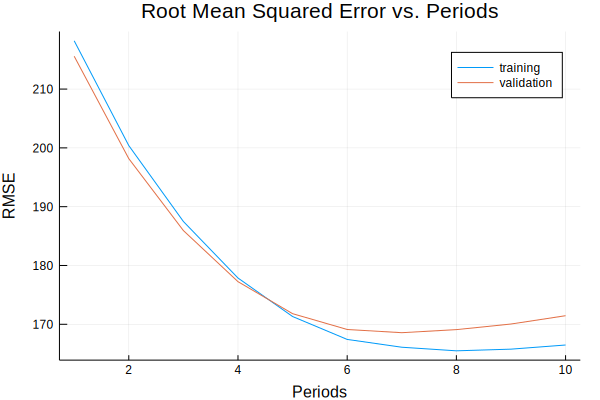

In [26]:
plot(p1)

## Task 5: Evaluate on Test Data

**In the cell below, load in the test data set and evaluate your model on it.**

We've done a lot of iteration on our validation data.  Let's make sure we haven't overfit to the pecularities of that particular sample. The test data set is located [here](https://storage.googleapis.com/mledu-datasets/california_housing_test.csv).

How does your test performance compare to the validation performance?  What does this say about the generalization performance of your model?

In [27]:
california_housing_test_data  = CSV.read("california_housing_test.csv", delim=",");

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

test_predictions = construct_columns(test_examples)*weight .+ bias

test_mean_squared_error = mean((test_predictions- construct_columns(test_targets)).^2)
test_root_mean_squared_error = sqrt(test_mean_squared_error)

print("Final RMSE (on test data): ", test_root_mean_squared_error)

Final RMSE (on test data): 161.49519916004172

In [28]:
# end of file